In [168]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
#from cv2 import imshow

In [169]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
custom_training = False

In [170]:
print(dataset.keys())

dict_keys(['train', 'test'])


In [171]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [172]:
def get_image_and_mask(index, dataset):
  #Turn it into a list
  the_list = list(dataset)
  #Get the image and mask tensors
  mask_tensor = the_list[index]['segmentation_mask']
  image_tensor = the_list[index]['image']
  #Convert the tensors into plotable arrays
  mask_array = np.array(mask_tensor)
  image_array = np.array(image_tensor)
  return image_array, mask_array

def display_image(image_array, title):
  plt.imshow(image_array)
  plt.title(title)
  plt.show()
  pass

#Function to plot multple images in a row
def display_images_together(images_list):
  fig = plt.figure(figsize=(15, 15))
  rows = 1
  columns = len(images_list)

  if columns > 3:
    print("Too many images in the list. Returning")
    return
  
  fig.add_subplot(rows, columns, 1)
  plt.imshow(images_list[0])
  plt.title("Image")

  fig.add_subplot(rows, columns, 2)
  plt.imshow(images_list[1])
  plt.title("Segmented Image")

  if columns == 3:
    fig.add_subplot(rows, columns, 3)
    plt.imshow(images_list[2])
    plt.title("Prediction mask")
    pass
  plt.show()
  pass

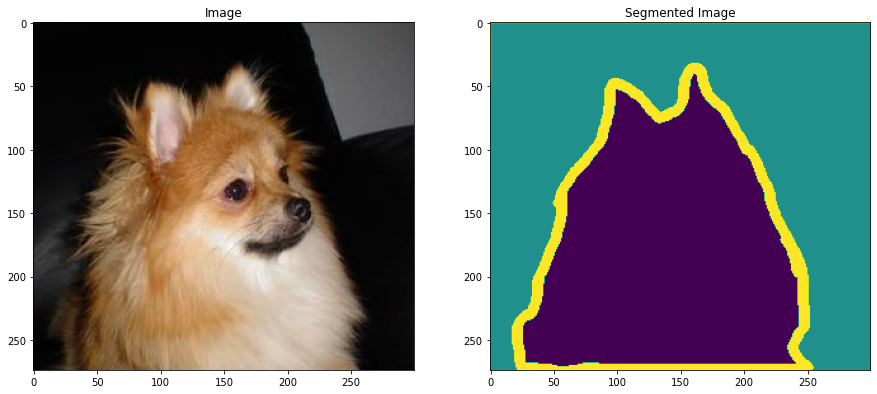

In [173]:
train_example_image, train_example_mask = get_image_and_mask(random.randint(0,len(list(train_dataset))), train_dataset) #Get a random set of images and it's mask from the dataset
display_images_together([train_example_image, train_example_mask])

In [174]:
#Prepare the datasets

#Need functions to load each datapoint from the original dataset into the augmented, resized and normalized dataset

#Need augmentation functions. In the future, double or quadruple the dataset size by adding all augmentations of the same image to the dataset


#Need an augmentation function to be used in the load_train_images
def augment_random_flip(input_image, input_mask):
    random_number = random.random()
    if random_number <= 0.5:
        #Flip the image
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        pass
    return input_image, input_mask

def normalize_inputs(input_image, input_mask):
    #Normalize pixels from 0 - 1 from 0 to 255
    input_image = tf.cast(input_image, tf.float32)/255
    #Original range is 1-3. Normalize them from 0-2
    input_mask = input_mask -1 #The labels are now: 0:pet   1:background and 2:outline
    return input_image, input_mask




def load_train_images(datapoint):
    #Input shape to the network:
    input_shape = (128, 128)
    #Each datapoint contains an image and a segmentation mask
    image = datapoint['image']
    mask = datapoint['segmentation_mask']

    #Resize both of them. They have to perfectly correspond to each other
    image = tf.image.resize(image, input_shape, method = 'nearest')
    mask = tf.image.resize(mask, input_shape, method = 'nearest')

    #augment the images
    flipped_image, flipped_mask = augment_random_flip(input_image=image, input_mask=mask)

    #Normalize them
    normalized_image, normalized_mask = normalize_inputs(flipped_image, flipped_mask)

    return normalized_image, normalized_mask

def load_test_images(datapoint):
    #Input shape to the network:
    input_shape = (128, 128)
    #Each datapoint contains an image and a segmentation mask
    image = datapoint['image']
    mask = datapoint['segmentation_mask']

    #Resize both of them. They have to perfectly correspond to each other
    image = tf.image.resize(image, input_shape, method = 'nearest')
    mask = tf.image.resize(mask, input_shape, method = 'nearest')

    #DO NOT augment the images

    #Normalize them
    normalized_image, normalized_mask = normalize_inputs(image, mask)

    return normalized_image, normalized_mask

In [175]:
train_dataset = dataset['train'].map(load_train_images, num_parallel_calls = tf.data.experimental.AUTOTUNE) #, num_parallel_calls=tf.data.experimental.AUTOTUNE)
temp_test_dataset = dataset['test']
test_dataset = dataset['test'].map(load_test_images)

In [176]:
#Finalize the datasets

BATCH_SIZE = 8
BUFFER_SIZE = max(len(train_dataset), len(test_dataset))
#Do not randomize in chunks
shuffle_buffer_size = BUFFER_SIZE

train_dataset = train_dataset.cache().shuffle(shuffle_buffer_size).batch(BATCH_SIZE) #Prefetch if it's not processing fast enough. But it will cost batch size
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE)

In [177]:
import os
cwd = os.getcwd()
print(cwd) #Place image in this folder

c:\Users\allan\OneDrive\Desktop\Pet Segmentation


<img src = "unet_picture.png" width = "800">

In [178]:
#The architecture to use is described in the picture above

#List of things to create:
'''
1. Convolutional block of 2 layers. Parameters: input layer, number of filters and kernel size
2. Encoding layer which takes in the input layer, processes it using a convolutional block and outputs a max pooled/downscaled layer
3. A single bottleneck block (At the bottom of the Unet)
4. A decoding layer which takes in an input layer, upscales(conv2dtranspose) concatenates it with the corresponding encoding layer and processes it with a conv block.
5. A final output layer which comresses the last conv block into a conv layer with 3 filters (filters = number of classes)
'''

'\n1. Convolutional block of 2 layers. Parameters: input layer, number of filters and kernel size\n2. Encoding layer which takes in the input layer, processes it using a convolutional block and outputs a max pooled/downscaled layer\n3. A single bottleneck block (At the bottom of the Unet)\n4. A decoding layer which takes in an input layer, upscales(conv2dtranspose) concatenates it with the corresponding encoding layer and processes it with a conv block.\n5. A final output layer which comresses the last conv block into a conv layer with 3 filters (filters = number of classes)\n'

In [179]:
def conv2D_block(input_layer, num_of_filters):
    #Hard coding this one for now
    kernel_size = (3,3)
    conv1_layer = tf.keras.layers.Conv2D(filters = num_of_filters, kernel_size = kernel_size, padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    act1 = tf.keras.layers.ReLU()(conv1_layer)
    conv2_layer = tf.keras.layers.Conv2D(filters = num_of_filters, kernel_size = kernel_size, padding = 'same', kernel_initializer = 'he_normal')(act1) #The input and output shapes will be identical because of padding
    act2 = tf.keras.layers.ReLU()(conv2_layer)
    return act2

In [180]:
def encoding_layer(input_layer, num_of_filters, dropout):
    #Pool size is always (2,2) and strides = always (2,2)
    pool_size = (2,2)
    strides = (2,2)
    encoding_layer_output = conv2D_block(input_layer=input_layer, num_of_filters=num_of_filters)
    #Maxpool and dropout (optional)
    #save the output because we need it for concatenating later
    max_pooled_layer = tf.keras.layers.MaxPool2D(pool_size= pool_size, strides = strides)(encoding_layer_output) #Down sampled here
    dropout_layer = tf.keras.layers.Dropout(dropout)(max_pooled_layer)
    return encoding_layer_output, dropout_layer

In [181]:
def entire_encoder(input_layer):
    #Declare filters
    first_block_filters = 64
    second_block_filters = first_block_filters*2 #128
    third_block_filters = second_block_filters*2 #256
    fourth_block_filters = third_block_filters*2 #512

    block1_encoding_layer_output, block1_dropout_layer = encoding_layer(input_layer=input_layer, num_of_filters=first_block_filters, dropout=0.3)
    block2_encoding_layer_output, block2_dropout_layer = encoding_layer(input_layer=block1_dropout_layer, num_of_filters=second_block_filters, dropout=0.3)
    block3_encoding_layer_output, block3_dropout_layer = encoding_layer(input_layer=block2_dropout_layer, num_of_filters=third_block_filters, dropout=0.3)
    block4_encoding_layer_output, block4_dropout_layer = encoding_layer(input_layer=block3_dropout_layer, num_of_filters=fourth_block_filters, dropout=0.3)
    
    encoder_output = block4_dropout_layer
    concat_layers = [block1_encoding_layer_output, block2_encoding_layer_output, block3_encoding_layer_output, block4_encoding_layer_output]

    filters = [first_block_filters, second_block_filters, third_block_filters, fourth_block_filters]

    return encoder_output, concat_layers, filters


In [182]:
def bottleneck_layer(input_layer, num_of_filters): #input is the encoder output
    return conv2D_block(input_layer=input_layer, num_of_filters=num_of_filters)

In [183]:
#Done with the encoding side. Now to build the decoder.

def decoder_layer(input_layer, layer_to_concat, transpose_filters, transpose_kernel_size, transpose_strides, dropout): #Transpose kernel size can be changed because padding is 'same'
    #start with the input layer
    x = input_layer
    #Upscale it
    x = tf.keras.layers.Conv2DTranspose(filters = transpose_filters, strides = transpose_strides, kernel_size = transpose_kernel_size, padding = 'same')(x)
    #Concatenate it
    x = tf.keras.layers.concatenate([x, layer_to_concat])
    #Regularize it
    x = tf.keras.layers.Dropout(rate = dropout)(x)

    #Run it through the conv block and output it after the 2 conv2d layers (Green arrow to green arrow)
    x = conv2D_block(x, num_of_filters=transpose_filters) #After concatenation, compress it to the size of the block before concatenation
    return x

In [184]:
#Build the whole decoder side using decoder layers and encoder layers (For concatenation)

def entire_decoder(bottleneck_output, concat_layers, filters_list):
    concat1, concat2, concat3, concat4 = concat_layers
    filter1, filter2, filter3, filter4 = filters_list
    decoder_layer1 = decoder_layer(bottleneck_output, layer_to_concat =concat4, transpose_filters=filter4, transpose_kernel_size=(3,3), transpose_strides=(2,2), dropout=0.3)
    decoder_layer2 = decoder_layer(decoder_layer1, layer_to_concat =concat3, transpose_filters=filter3, transpose_kernel_size=(3,3), transpose_strides=(2,2), dropout=0.3)
    decoder_layer3 = decoder_layer(decoder_layer2, layer_to_concat =concat2, transpose_filters=filter2, transpose_kernel_size=(3,3), transpose_strides=(2,2), dropout=0.3)
    decoder_layer3 = decoder_layer(decoder_layer3, layer_to_concat =concat1, transpose_filters=filter1, transpose_kernel_size=(3,3), transpose_strides=(2,2), dropout=0.3)
    return decoder_layer3
    

In [185]:
def output_layer(input_layer, num_of_classes): #Input layer should be the entire decoder
    network_output = tf.keras.layers.Conv2D(filters = num_of_classes, kernel_size = (1,1), strides = (1,1), activation = 'softmax')(input_layer)
    return network_output

In [186]:
def Unet(num_of_classes):
    #Define the input shape
    input_layer = tf.keras.layers.Input(shape = (128,128,3))
    #Encoder part of the U shape
    encoder_output, concat_layers, filters_list = entire_encoder(input_layer=input_layer)

    f5 = filters_list[-1]*2
   
    #Bottleneck part of the U shape
    bottleneck_output = bottleneck_layer(encoder_output, f5)

    #Build the decoder
    decoder_output = entire_decoder(bottleneck_output=bottleneck_output, concat_layers=concat_layers, filters_list=filters_list)

    #Finally the output layer with filters = num of classes
    network_output = output_layer(decoder_output, num_of_classes=num_of_classes)

    #Build the model from the layers
    my_model = tf.keras.Model(inputs = input_layer, outputs = network_output)   
    return my_model

In [187]:
the_Unet = Unet(3)

In [188]:
the_Unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 128, 128, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu_90 (ReLU)                (None, 128, 128, 64  0           ['conv2d_95[0][0]']              
                                )                                                           

In [189]:
def learning_rate_scheduler(epoch, lr):
    factor = 0.9
    return lr*factor

In [190]:
learning_rate_decay_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
my_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00011)
loss_calculator = tf.keras.losses.SparseCategoricalCrossentropy()
train_metric = tf.keras.metrics.SparseCategoricalAccuracy()
the_Unet.compile(optimizer=my_optimizer, loss = loss_calculator, metrics=train_metric)
lowest_loss = 500

In [191]:
#Automated training loop
EPOCHS = 22

def early_stop_callback(batch, logs):
    #Get current loss
    current_loss = logs.get('val_loss')
    
    #Check if it's the lowest loss so far
    if (current_loss < lowest_loss and current_loss < 0.30):
        lowest_loss = current_loss
        pass
    #If the loss is increasing, it is over fitting
    if current_loss >= 1.2 * lowest_loss:
        the_Unet.stop_training = True

        pass
    pass


#my_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end = early_stop_callback)
if not custom_training:
    model_history = the_Unet.fit(train_dataset, validation_data=test_dataset, epochs = EPOCHS, callbacks=[learning_rate_decay_callback]) #disabled the callback for now
                     

Epoch 1/22
460/460 [==============================] - 71s 146ms/step - loss: 0.7702 - sparse_categorical_accuracy: 0.6849 - val_loss: 0.6361 - val_sparse_categorical_accuracy: 0.7507 - lr: 9.9000e-05
Epoch 2/22
460/460 [==============================] - 66s 144ms/step - loss: 0.5712 - sparse_categorical_accuracy: 0.7746 - val_loss: 0.5399 - val_sparse_categorical_accuracy: 0.7869 - lr: 8.9100e-05
Epoch 3/22
460/460 [==============================] - 63s 138ms/step - loss: 0.4830 - sparse_categorical_accuracy: 0.8123 - val_loss: 0.4654 - val_sparse_categorical_accuracy: 0.8157 - lr: 8.0190e-05
Epoch 4/22
460/460 [==============================] - 65s 141ms/step - loss: 0.4326 - sparse_categorical_accuracy: 0.8322 - val_loss: 0.4251 - val_sparse_categorical_accuracy: 0.8365 - lr: 7.2171e-05
Epoch 5/22
460/460 [==============================] - 69s 150ms/step - loss: 0.4018 - sparse_categorical_accuracy: 0.8443 - val_loss: 0.3899 - val_sparse_categorical_accuracy: 0.8491 - lr: 6.4954e-05


In [203]:
#Get a random test image 
def get_random_test_images_masks(dataset): #Pass in test_dataset as parameter
    random_num = random.randint(0,200)
    for batch in dataset.take(random_num): #pick a random batch
        random_num = random.randint(0,BATCH_SIZE-1)
        batch_of_images = batch[0]
        batch_of_masks = batch[1]
        random_image = batch_of_images[random_num]
        random_mask = batch_of_masks[random_num]
        pass
    return random_image, random_mask

In [193]:
test_image, test_mask = get_random_test_images_masks(test_dataset)

def get_prediction_image_tensor(the_model, test_image):
    test_image_tensor = tf.Variable(test_image, dtype=tf.float32) #It's already a tensor
    test_image_tensor = tf.expand_dims(test_image_tensor, axis = 0)
    prediction_tensor = the_model(test_image_tensor) 
    return prediction_tensor



def get_mask(prediction_tensor):
    prediction_mask = tf.argmax(prediction_tensor, axis = -1)
    #print(prediction_mask.shape)
    return prediction_mask

def display_prediction(model, test_image, test_mask):
    prediction_tensor = get_prediction_image_tensor(model, test_image)
    prediction_mask = get_mask(prediction_tensor)
    prediction_mask = tf.expand_dims(prediction_mask[0], axis = -1)
    display_images_together([test_image, test_mask, prediction_mask]) 

In [194]:
#Custom training section
def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    plt.title("Training vs Validation loss")
    plt.plot(train_loss)
    plt.plot(val_loss)
    pass

def plot_custom_losses(custom_train_loss_history, custom_train_accuracy_history):
    plt.plot(custom_train_loss_history)
    pass

In [195]:
def train_batches_for_single_epoch(model, dataset, epoch_number, optimizer):
    train_losses = []
    train_accuracy = []
    for batch in dataset:
        image_batch = batch[0]
        mask_batch = batch[1]
        with tf.GradientTape() as tape:
            
           logits = model(image_batch) #Get predictions
           loss_value = loss_calculator(y_true = mask_batch, y_pred = logits) #Calculate the loss for those predictions
           train_losses.append(loss_value) #Save the loss
           gradients = tape.gradient(loss_value, model.trainable_weights) #differentiate the loss with respect to the trainable weights
           optimizer.apply_gradients(zip(gradients, model.trainable_weights)) #using the learning, modify the weights
           train_metric.update_state(mask_batch, logits) #Calculate crossentropy. Does not affect training
           train_accuracy.append(train_metric.result())
           #clear_output(wait=True)
           #print("Accuracy is" + str(train_metric.result()))
        pass
    print("Epoch: {2} Training loss = {0:.4f} || Training Accuracy = {1:.4f}".format(np.mean(train_losses), np.mean(train_accuracy), (epoch_number+1)))
    return train_losses, train_accuracy

In [196]:
def custom_training_loop(model, train_dataset, epochs, optimizer):
    all_train_losses = []
    all_train_accuracies = []
    for epoch in range(epochs):
        #For every epoch, train all batches
        epoch_train_losses, epoch_train_accuracies = train_batches_for_single_epoch(model, train_dataset, epoch, optimizer)
        #Save the batch-wise losses and metrics
        for loss, accuracy in zip(epoch_train_losses, epoch_train_accuracies):
            all_train_losses.append(loss)
            all_train_accuracies.append(accuracy)
            pass
        display_prediction(model, test_image=test_image, test_mask=test_mask)
        pass
    return all_train_losses, all_train_accuracies

In [197]:
if custom_training:
    custom_train_loss_history, custom_train_accuracy_history = custom_training_loop(the_Unet, train_dataset, EPOCHS, my_optimizer)

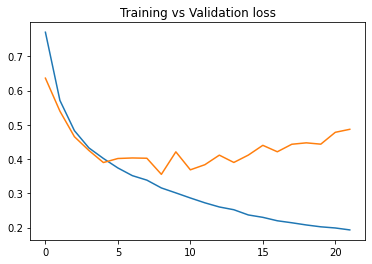

In [198]:
if not custom_training:
    plot_metrics(model_history.history)
else:
    plot_custom_losses(custom_train_loss_history, custom_train_accuracy_history)
    pass



Large diversions after epoch 6 or 7. The learning rate is too high at that point. Larger reduction factor in the learning rate scheduler. 
There is a constant trend after epoch 7 or 8. The loss is steadily increasing. It has overfit. Experiment with another initializer, the bias and increase the dropout. Shrink the network. 

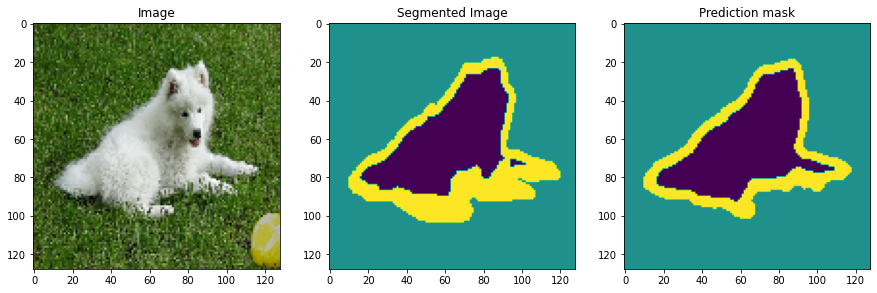

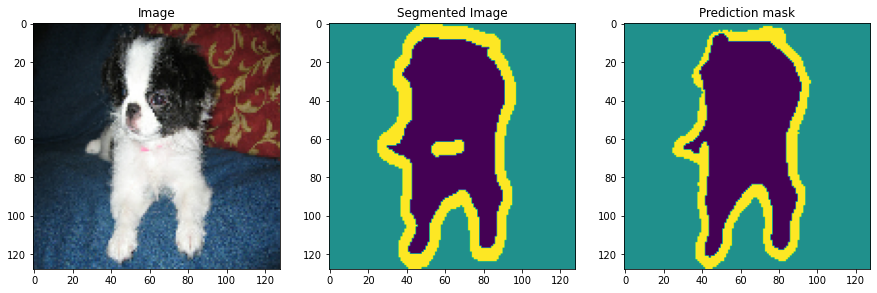

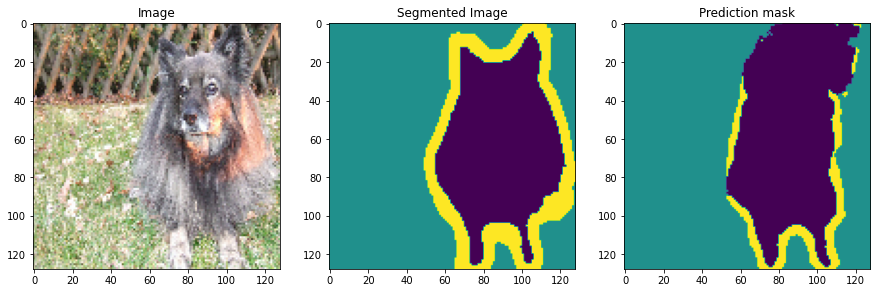

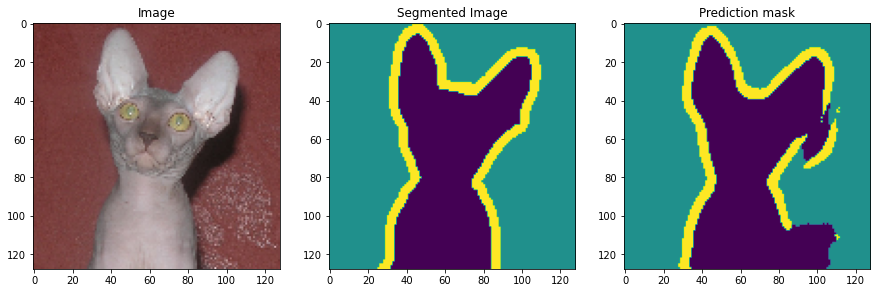

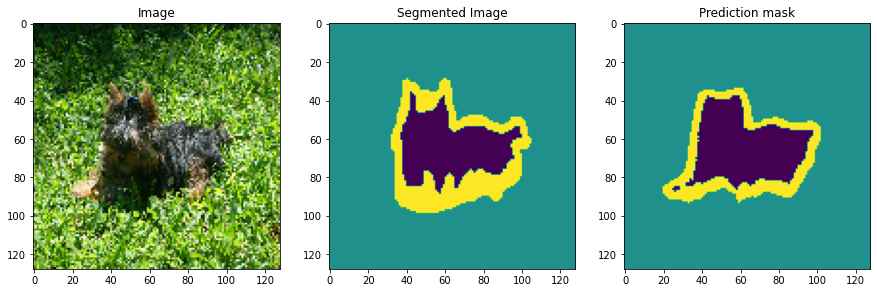

In [206]:
for i in range(5):
    test_image, test_mask = get_random_test_images_masks(test_dataset)
    display_prediction(the_Unet, test_image=test_image, test_mask=test_mask)
